## Problem 2

### Problem 2.1

In [9]:
import pandas as pd

In [10]:
training = pd.read_csv('training_dataset.csv')
testing_bodytrack = pd.read_csv('testing_bodytrack.csv')
testing_blackscholes = pd.read_csv('testing_blackscholes.csv')

In [11]:
# Make a label column. The label is "cluster active" if w_big > 1, and "cluster idle" otherwise.
training['y'] = training['w_big'].apply(lambda x: 0 if x > 1 else 1)
testing_bodytrack['y'] = testing_bodytrack['w_big'].apply(lambda x: 0 if x > 1 else 1)
testing_blackscholes['y'] = testing_blackscholes['w_big'].apply(lambda x: 0 if x > 1 else 1)

### Some data processing

In [12]:
import numpy as np
from scipy import stats
zscore = np.abs(stats.zscore(training.select_dtypes(include=["float", "int"])))
ZSCORE_THREASHOLD = 4

is_inlier = ~ (zscore > ZSCORE_THREASHOLD).any(axis=1)
train_data = training[is_inlier]

In [13]:
# Shuffle the data
train_data = train_data.sample(frac=1).reset_index(drop=True)

### Create the pipeline for the model

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('pca', PCA(n_components=6)),
    ('scaler', StandardScaler())
])

### We chose to brute force our way to find some models that fits the test model good. RandomizedSearchCV did not produce good models... So brute-force is our way to go...

In [ ]:
from sklearn.svm import SVC

svm_c_range = np.logspace(-3, 3, 100)
svm_gamma_range = np.logspace(-3, 3, 100)
svm_kernels = ['sigmoid', 'rbf', 'poly']
svm_class_weights = ['balanced', None]
svm_decision_function_shapes = ['ovo', 'ovr']

results = {}

X = train_data.drop(['y'], axis=1)
X = X[:100]
y = train_data['y'][:100]

testing_bodytrack_x = testing_bodytrack.drop(['y'], axis=1)
testing_bodytrack_y = testing_bodytrack['y']

testing_blackscholes_x = testing_blackscholes.drop(['y'], axis=1)
testing_blackscholes_y = testing_blackscholes['y']
i = 0
print(len(svm_kernels) * len(svm_class_weights) * len(svm_decision_function_shapes) * len(svm_c_range) * len(svm_gamma_range))
for kernel in svm_kernels:
    for class_weight in svm_class_weights:
        for decision_function_shape in svm_decision_function_shapes:
            for c in svm_c_range:
                for gamma in svm_gamma_range:
                    model = Pipeline(steps=[
                        ('preprocessor', numerical_transformer),
                        ('classifier', SVC(kernel=kernel, class_weight=class_weight, decision_function_shape=decision_function_shape, C=c, gamma=gamma, random_state=42, max_iter=10000))
                    ])

                    model.fit(X, y)
                    acc = model.score(X, y)
                    test_bodytrack_acc = model.score(testing_bodytrack_x, testing_bodytrack_y)
                    test_blackscholes_acc = model.score(testing_blackscholes_x, testing_blackscholes_y)
                    results[(kernel, class_weight, decision_function_shape, c, gamma)] = (acc, test_bodytrack_acc, test_blackscholes_acc)
                    i += 1
                    if i % 1000 == 0:
                        print(i)

### We find passable models, and also the best models for bodytrack and blackscholes. Print them.

In [22]:
passable = [x for x in results if results[x][1] > 0.98 and results[x][2] > 0.98]
best_bodytrack = max(results, key=lambda x: results[x][1])
best_blackscholes = max(results, key=lambda x: results[x][2])
best_average = max(results, key=lambda x: (results[x][1] + results[x][2]) / 2)

print(passable)
print(best_bodytrack, results[best_bodytrack])
print(best_blackscholes, results[best_blackscholes])

[('sigmoid', 'balanced', 'ovo', 4.328761281083062, 0.04328761281083059), ('sigmoid', 'balanced', 'ovo', 5.72236765935022, 0.03274549162877728), ('sigmoid', 'balanced', 'ovo', 6.5793322465756825, 0.0015199110829529332), ('sigmoid', 'balanced', 'ovo', 6.5793322465756825, 0.02848035868435802), ('sigmoid', 'balanced', 'ovo', 6.5793322465756825, 0.03274549162877728), ('sigmoid', 'balanced', 'ovo', 6.5793322465756825, 0.037649358067924674), ('sigmoid', 'balanced', 'ovo', 7.56463327554629, 0.024770763559917114), ('sigmoid', 'balanced', 'ovo', 7.56463327554629, 0.02848035868435802), ('sigmoid', 'balanced', 'ovo', 7.56463327554629, 0.03274549162877728), ('sigmoid', 'balanced', 'ovo', 7.56463327554629, 0.037649358067924674), ('sigmoid', 'balanced', 'ovo', 8.697490026177835, 0.0011497569953977356), ('sigmoid', 'balanced', 'ovo', 8.697490026177835, 0.024770763559917114), ('sigmoid', 'balanced', 'ovo', 8.697490026177835, 0.02848035868435802), ('sigmoid', 'balanced', 'ovo', 8.697490026177835, 0.0327

## One of the models that pass happens to be the best model for blackscholes so we might aswell use it

In [26]:
final_model = Pipeline(steps=[
    ('preprocessor', numerical_transformer),
    ('classifier', SVC(kernel=best_blackscholes[0], class_weight=best_blackscholes[1], decision_function_shape=best_blackscholes[2], C=best_blackscholes[3], gamma=best_blackscholes[4], random_state=42, max_iter=10000))
])

final_model.fit(X[:100], y[:100])
print(final_model.score(X[:100], y[:100]))
print(final_model.score(testing_bodytrack_x, testing_bodytrack_y))
print(final_model.score(testing_blackscholes_x, testing_blackscholes_y))

1.0
0.9855570839064649
1.0


Report for training
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1766
           1       1.00      1.00      1.00      3613

    accuracy                           1.00      5379
   macro avg       1.00      1.00      1.00      5379
weighted avg       1.00      1.00      1.00      5379



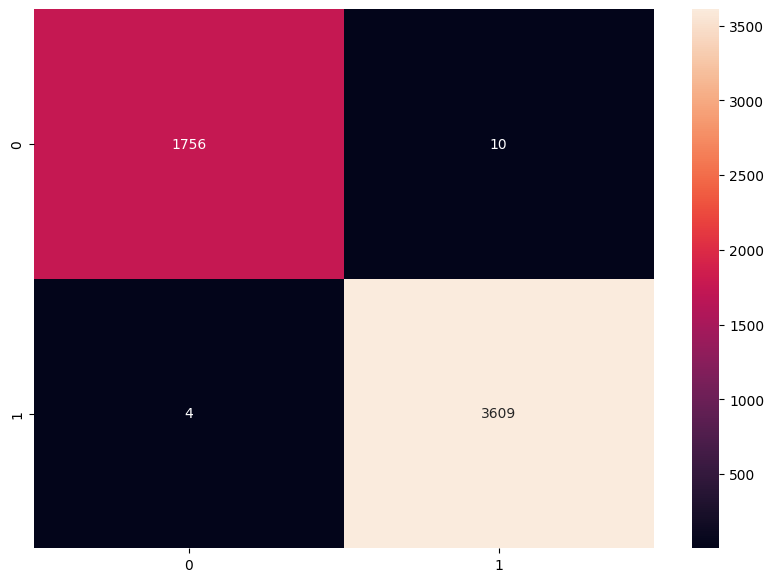

0.9973972857408441

Report for bodytrack
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       908
           1       1.00      0.96      0.98       546

    accuracy                           0.99      1454
   macro avg       0.99      0.98      0.98      1454
weighted avg       0.99      0.99      0.99      1454



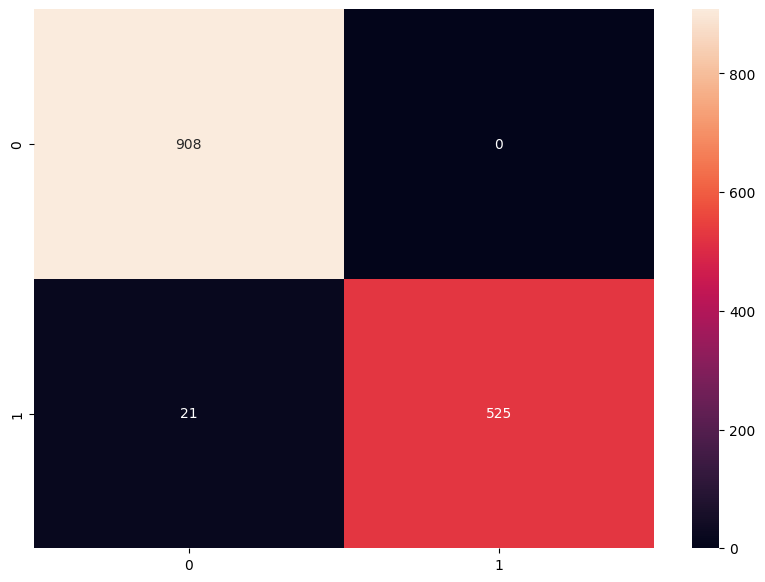

0.9855570839064649

Report for blackscholes
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1098
           1       1.00      1.00      1.00       555

    accuracy                           1.00      1653
   macro avg       1.00      1.00      1.00      1653
weighted avg       1.00      1.00      1.00      1653



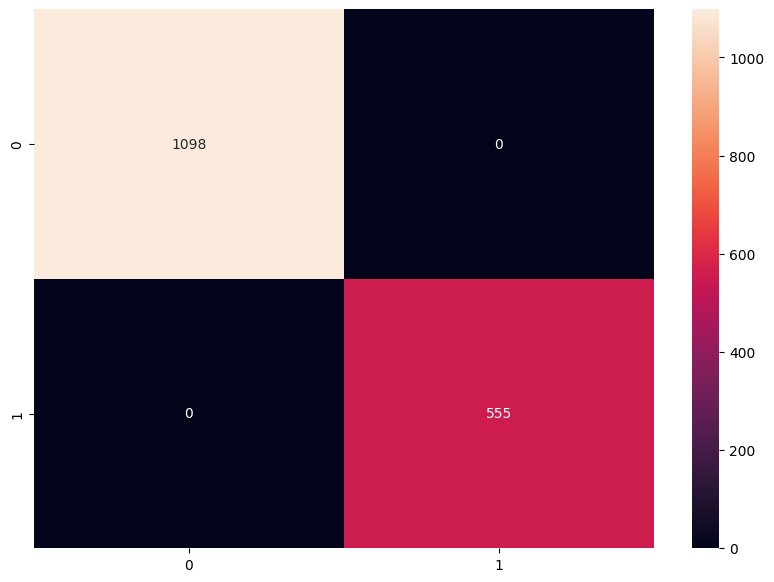

1.0


In [42]:
# Import classification report, confusion matrix, and accuracy score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on bodytrack and blackscholes
y_pred_bodytrack = final_model.predict(testing_bodytrack_x)
y_pred_blackscholes = final_model.predict(testing_blackscholes_x)
y_pred_train = final_model.predict(train_data.drop(['y'], axis=1))

print("Report for training")
# Print classification report and confusion matrix
print(classification_report(train_data['y'], y_pred_train))

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

cm = confusion_matrix(train_data['y'], y_pred_train)
df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                    columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.show()

print(accuracy_score(train_data['y'], y_pred_train))
print()

print("Report for bodytrack")
# Print classification report and confusion matrix
print(classification_report(testing_bodytrack_y, y_pred_bodytrack))

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

cm = confusion_matrix(testing_bodytrack_y, y_pred_bodytrack)
df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                    columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.show()

print(accuracy_score(testing_bodytrack_y, y_pred_bodytrack))
print()

print("Report for blackscholes")
# Print classification report and confusion matrix on blackscholes
print(classification_report(testing_blackscholes_y, y_pred_blackscholes))

# Plot confusion matrix
cm = confusion_matrix(testing_blackscholes_y, y_pred_blackscholes)
df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                    columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.show()

print(accuracy_score(testing_blackscholes_y, y_pred_blackscholes))

## Table 2
<table>
  <tr>
    <th></th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td><b>Bodytrack</b></td>
    <td>0.9855570839064649</td>
    <td>0.99</td>
    <td>0.99</td>
    <td>0.98</td>
  </tr>
  <tr>
    <td><b>Blackscholes</b></td>
    <td>1.0</td>
    <td>1.0</td>
    <td>1.0</td>
    <td>1.0</td>
  </tr>
</table>

## Problem 2.2

In [6]:
import pandas as pd

training = pd.read_csv('training_dataset.csv')
blackscholes = pd.read_csv('testing_blackscholes.csv')
bodytrack = pd.read_csv('testing_bodytrack.csv')

datasets = {"training": training, "blackscholes": blackscholes, "bodytrack": bodytrack}

Dataset: training
r^2: 0.9869761626648632
MSE: 0.010151781665943441



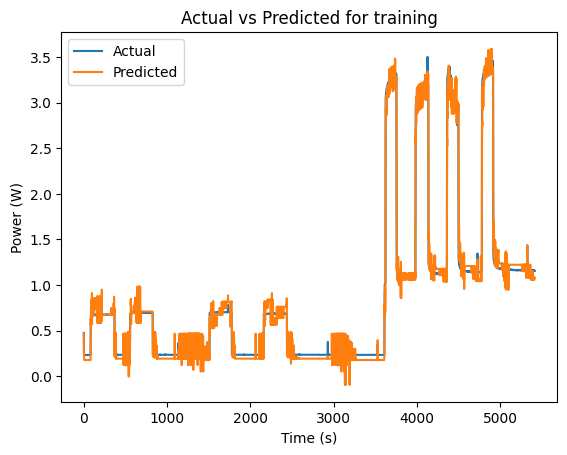

Dataset: blackscholes
r^2: 0.9566269813153525
MSE: 0.05941814652611627



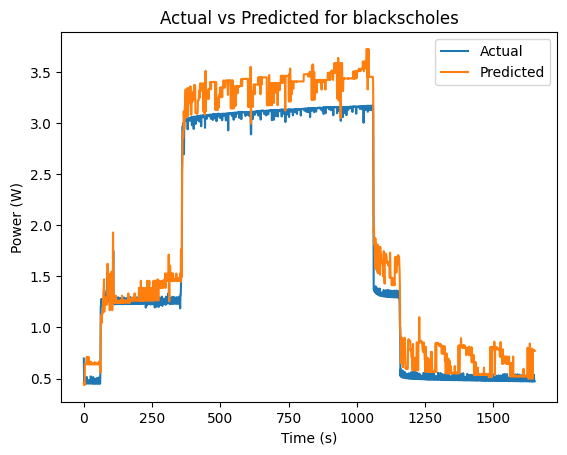

Dataset: bodytrack
r^2: 0.9224313607555271
MSE: 0.12156466261471592



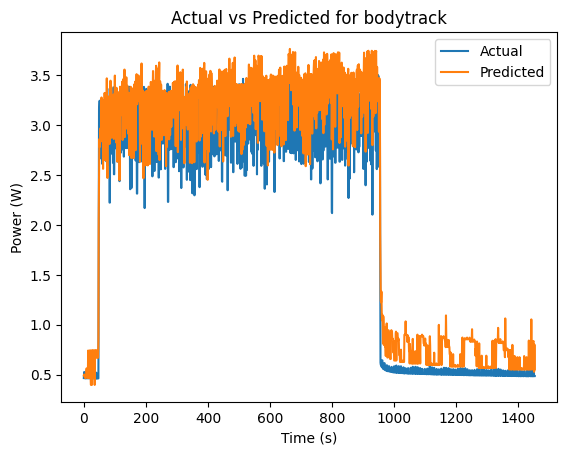

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np

x_training = training.drop(["total_watts", "w_big", "w_little", "w_gpu", "w_mem"], axis=1)
y_training = training["w_big"]

reg = LinearRegression()
reg.fit(x_training, y_training)

for dataset_name in datasets.keys():
    x = datasets[dataset_name].drop(["total_watts", "w_big", "w_little", "w_gpu", "w_mem"], axis=1)
    y = datasets[dataset_name]["w_big"]
    r2 = r2_score(y, reg.predict(x))
    y_pred = reg.predict(x)
    mse = np.mean((y_pred - y)**2)

    print("Dataset: {}".format(dataset_name))
    print("r^2: {}".format(r2))
    print("MSE: {}".format(mse))
    print()

    import matplotlib.pyplot as plt
    # Make an x-axis that is the same length as the number of rows in the dataset
    x_axis = np.arange(0, len(y), 1)

    # Predict the y values
    y_pred = reg.predict(x)

    # Plot the actual y values
    plt.plot(x_axis, y, label="Actual")

    # Plot the predicted y values
    plt.plot(x_axis, y_pred, label="Predicted")

    plt.xlabel("Time (s)")
    plt.ylabel("Power (W)")

    # Add a legend
    plt.legend()

    # Add a title
    plt.title("Actual vs Predicted for {}".format(dataset_name))

    # Show the plot
    plt.show()

## Table 3

<table>
  <tr>
    <th>Dataset</th>
    <th><b>Training</b></th>
    <th><b>Blackscholes</b></th>
    <th><b>Bodytrack</b></th>
  </tr>
  <tr>
    <td>R^2</td>
    <td>0.9869761626648632</td>
    <td>0.9566269813153525</td>
    <td>0.9224313607555271</td>
  </tr>
  <tr>
    <td>MSE</td>
    <td>0.010151781665943441</td>
    <td>0.05941814652611627</td>
    <td>0.12156466261471592</td>
  </tr>
</table>

## Problem 2.3

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
training = pd.read_csv('training_dataset.csv')

In [3]:
voltages = [0.975, 1, 1.1375, 1.362]
frequencies = [0.9, 1, 1.5, 2]
frequencies = [f * 1e9 for f in frequencies]

# Map voltages to frequencies
frequency_to_voltage = dict(zip(frequencies, voltages))

In [4]:
# Using the frequency_to_voltage map, create a new column in the training dataset that is calculated by V^2 * f
training['Dynamic Power'] = training['freq_big_cluster'].map(frequency_to_voltage) ** 2 * training['freq_big_cluster']

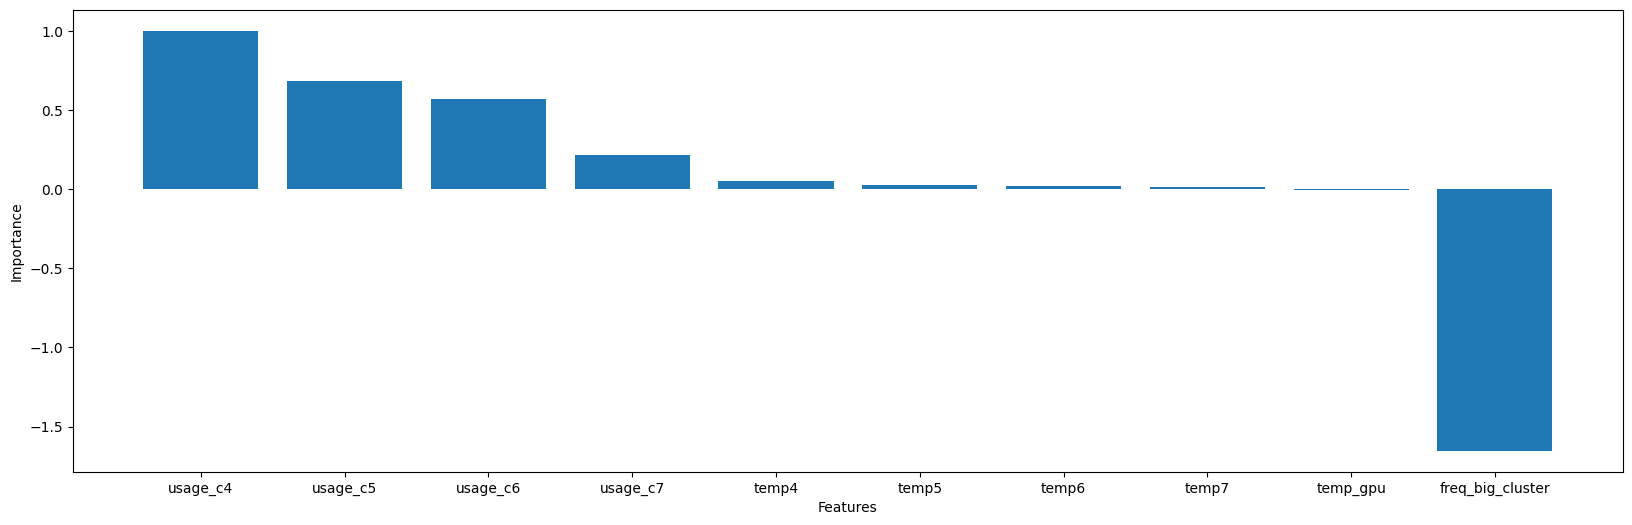

In [8]:
x = training.drop(columns=["total_watts", "w_big", "w_little", "w_gpu", "w_mem"])
y= training["w_big"]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

for i, column in enumerate(x.columns):
    x_scaled = x_scaled.rename(columns={i: str(x.columns[i])})

reg = LinearRegression()

reg.fit(x_scaled, y)

importance = reg.coef_
importance = importance[importance.argsort()[::-1]]
x_scaled = x_scaled.columns[importance.argsort()[::-1]]

plt.figure(figsize=(20,6))
plt.bar(x_scaled, importance)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()